In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy
import jaxopt

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot
import src.exp_utils as exp_utils
import experiments.tail as exp_tail

plt.rcParams["mathtext.fontset"] = "cm"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [6]:
np.random.seed(2024)

In [7]:
dim = 1
n = 10000
dof = 100

scale = jnp.sqrt((dof - 2) / dof)
Xs = np.random.standard_t(df=dof, size=(n, dim)) * scale

In [8]:
Xs.mean(), Xs.std()

(Array(0.00363252, dtype=float32), Array(1.0031178, dtype=float32))

# Load

In [9]:
n = 500
d = 1
res_stats = pickle.load(open(f"../data/tail/stats_n{n}_d{d}.pkl", "rb"))

dof_ls = list(res_stats.keys())
dof_ls

[3, 5, 10, 20, 50, 100, 200]

In [12]:
# change theta
eps0_ls = [0.05, 0.1, 0.25]
dof_threshold_ls = [5, 10, 20]
plot_df_ls = {}
nu_lb = {}

for i, eps0 in enumerate(eps0_ls):
    # change theta
    res_stats_new = copy.deepcopy(res_stats)
    for dof in dof_ls:
        tau = np.array(res_stats[dof]["tilted_r_boot"]["tau"])
        # theta_new = eps0 * tau**0.5
        theta_new = exp_tail.compute_theta_fat_tail(dof_threshold_ls[i], tau)
        
        res_stats_new[dof] = exp_utils.change_theta(res_stats_new[dof], ["tilted_r_boot"], theta_new)

        # compute lower bound on dof so that KSD(Q, P) <= \theta + o(1)
        # nu_lb[dof] = 0. # exp_tail.compute_nu_threshold(theta=theta_new, tau=tau[dof])
        nu_lb[dof] = dof_threshold_ls[i]
    
    methods = {"standard": "IMQ", "tilted": "Tilted", "tilted_r_boot": "R-KSD"}
    
    plot_df = {"dof": [], "nonsq_stat": [], "method": [], "rej": [], "dof_lb": []}
    for dof in dof_ls:
        for m, m_label in methods.items():
            rr = res_stats_new[dof][m]
            plot_df["nonsq_stat"].extend(np.array(rr["nonsq_stat"]).tolist())
            plot_df["dof"].extend([dof] * len(rr["nonsq_stat"]))
            
            plot_df["rej"].extend(rr["rej"])
            plot_df["method"].extend([m_label] * len(rr["nonsq_stat"]))

            plot_df["dof_lb"].extend([nu_lb[dof]] * len(rr["nonsq_stat"]))
    
    plot_df = pd.DataFrame(plot_df)
    plot_df_ls[eps0] = plot_df

In [13]:
for eps0 in eps0_ls:
    print(plot_df_ls[eps0].dof_lb.unique())
    # print(tau[dof]**0.5)

[5]
[10]
[20]


/tmp/ipykernel_270151/7777730.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_plot_df.replace({"method": {"R-KSD": rf"R-KSD ($\nu_0$={dof_threshold_ls[i]})"}}, inplace=True)


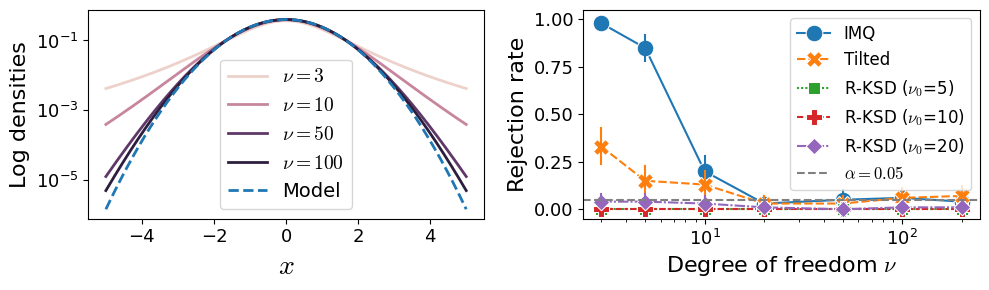

In [17]:
_, axes = plt.subplots(ncols=2, figsize=(10, 3))

# 1. show model and data densities
x_plot = jnp.linspace(-5., 5., 1001)
model_pdf = jax.scipy.stats.norm.pdf(x_plot)

den_df = {"x": [], "den": [], "dof": []}
for dof in [3, 10, 50, 100]:
    data_pdf = exp_tail.t_pdf_multivariate(x_plot.reshape((-1, 1)), df=dof).tolist()
    den_df["x"].extend(x_plot.tolist())
    den_df["den"].extend(data_pdf)
    den_df["dof"].extend([dof] * len(x_plot))
den_df = pd.DataFrame(den_df)

ax = axes[0]
g1 = sns.lineplot(ax=ax, data=den_df, x="x", y="den", hue=np.log(den_df.dof), legend="full", linewidth=2)
g2 = ax.plot(x_plot, model_pdf, color="C0", linestyle="--", label="Model", linewidth=2)
ax.set_xlabel(r"$x$", fontsize=20)
ax.set_ylabel("Log densities", fontsize=16)
ax.set_yscale("log")
ax.tick_params(axis="both", labelsize=13)
ax.legend(handles=g1.get_legend().legend_handles + g2, labels=[rf"$\nu={r}$" for r in den_df.dof.unique().tolist()] + ["Model"], fontsize=14)

# 2. plot rej probs
# append results df and change method labels
plot_df = plot_df_ls[eps0_ls[0]].copy()
plot_df = plot_df.loc[(plot_df.method == "IMQ") | (plot_df.method == "Tilted")]
for i, eps0 in enumerate(eps0_ls):
    sub_plot_df = plot_df_ls[eps0]
    sub_plot_df = sub_plot_df.loc[sub_plot_df.method == "R-KSD"]
    sub_plot_df.replace({"method": {"R-KSD": rf"R-KSD ($\nu_0$={dof_threshold_ls[i]})"}}, inplace=True)
    plot_df = pd.concat([plot_df, sub_plot_df], ignore_index=True)

ax = axes[1]
_ = sns.lineplot(ax=ax, data=plot_df, x="dof", y="rej", hue="method", style="method", markers=True, err_style="bars", markersize=12)
ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
ax.set_xlabel(r"Degree of freedom $\nu$", fontsize=16)
ax.set_ylabel("Rejection rate", fontsize=16)
ax.tick_params(axis="both", labelsize=13)
ax.set_ylim(-0.05, 1.05)
ax.set_xscale("log")

lgd = ax.legend(fontsize=12)
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.savefig("../figs/robust/tail.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

In [23]:
import scipy
scipy.stats.norm.pdf(0)

0.3989422804014327

In [24]:
scipy.stats.t.pdf(0, 2)

0.3535533905932738

In [21]:
# # nu_ls
# a = 2.
# cdfvals = [scipy.stats.t.cdf(a, nu) for nu in nu_ls]
# plt.scatter(nu_ls, cdfvals)

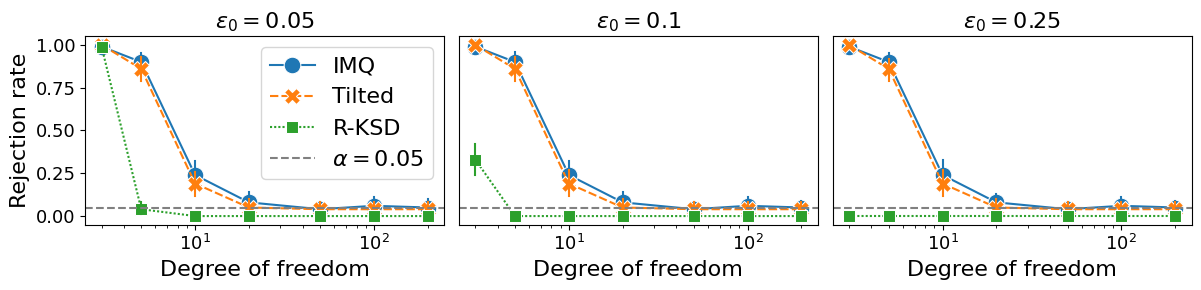

In [9]:
_, axes = plt.subplots(ncols=len(eps0_ls), figsize=(4*len(eps0_ls), 3))

for i, eps0 in enumerate(eps0_ls):
    plot_df = plot_df_ls[eps0]

    ax = axes[i]
    _ = sns.lineplot(ax=ax, data=plot_df, x="dof", y="rej", hue="method", style="method", markers=True, err_style="bars", markersize=12)
    ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
    # ax.axvline(plot_df_ls[eps0].dof_lb.unique()[0], color="grey")
    ax.set_xlabel("Degree of freedom", fontsize=16)
    ax.set_ylabel("Rejection rate", fontsize=16)
    ax.set_title(rf"$\epsilon_0 = ${eps0}", fontsize=16)
    ax.tick_params(axis="both", labelsize=13)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xscale("log")
    if i > 0:
        ax.legend([],[], frameon=False)
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

# lgd = axes[0].legend(bbox_to_anchor=(0.4, 1.11, 1, 0.2), loc="lower left", ncol=6, fontsize=16)
lgd = axes[0].legend(fontsize=16)

# plt.subplots_adjust(wspace=0.1)
# plt.savefig("../figs/robust/tail.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

plt.tight_layout()
# plt.savefig("../figs/robust/tail.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

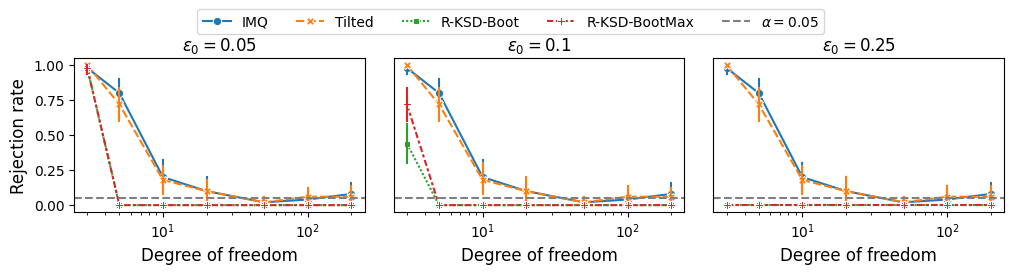

In [7]:
_, axes = plt.subplots(ncols=len(eps0_ls), figsize=(4*len(eps0_ls), 2))

for i, eps0 in enumerate(eps0_ls):
    plot_df = plot_df_ls[eps0]

    ax = axes[i]
    _ = sns.lineplot(ax=ax, data=plot_df, x="dof", y="rej", hue="method", style="method", markers=True, err_style="bars")
    ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
    ax.set_xlabel("Degree of freedom", fontsize=12)
    ax.set_ylabel("Rejection rate", fontsize=12)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xscale("log")
    ax.set_title(rf"$\epsilon_0 = ${eps0}")
    if i > 0:
        ax.legend([],[], frameon=False)
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

lgd = axes[0].legend(bbox_to_anchor=(0.4, 1.11, 1, 0.2), loc="lower left", ncol=6)

plt.subplots_adjust(wspace=0.1)
# plt.savefig("../figs/robust/tail.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

In [135]:
# show model and data densities

x_plot = jnp.linspace(-5., 5., 1001)
model_pdf = jax.scipy.stats.norm.pdf(x_plot)

den_df = {"x": [], "den": [], "dof": []}
for dof in [3, 10, 50, 100]:
    data_pdf = exp_tail.t_pdf_multivariate(x_plot.reshape((-1, 1)), df=dof).tolist()
    den_df["x"].extend(x_plot.tolist())
    den_df["den"].extend(data_pdf)
    den_df["dof"].extend([dof] * len(x_plot))
den_df = pd.DataFrame(den_df)

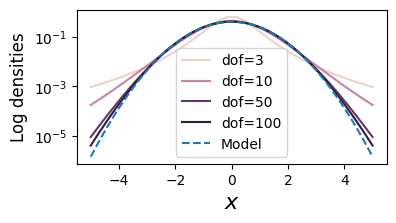

In [175]:
_, ax = plt.subplots(figsize=(4, 2))

# g1 = sns.lineplot(ax=ax, data=den_df, x="x", y="den", hue="dof", legend="full")
g1 = sns.lineplot(ax=ax, data=den_df, x="x", y="den", hue=np.log(den_df.dof), legend="full")
g2 = ax.plot(x_plot, model_pdf, color="C0", linestyle="--", label="Model")
ax.set_xlabel(r"$x$", fontsize=16)
ax.set_ylabel("Log densities", fontsize=12)
ax.set_yscale("log")
ax.legend(handles=g1.get_legend().legend_handles + g2, labels=[f"dof={r}" for r in den_df.dof.unique().tolist()] + ["Model"])
# plt.savefig("../figs/robust/tail_den.pdf", bbox_inches="tight")